<a href="https://colab.research.google.com/github/pelinsuciftcioglu/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Auto-Encoder (VAE)**

VAE implementation inspired by:
- [Tomczak, J. M. (2021). Introduction to Deep Generative Modeling.](https://https://github.com/jmtomczak/intro_dgm)
- [CreativeAI: Deep Learning for Graphics Tutorial Code
](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb)





In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils
import torch.distributions
import torchvision
from torch import autograd  # TO USE "with autograd.detect_anomaly():"
import numpy as np
import matplotlib.pyplot as plt

import os

use_gpu = True

In [2]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

# DISTRBUTION FOR THE DATA (INPUT)

def log_categorical(x, x_new, num_classes, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(x_new, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_bernoulli(x, x_new, reduction=None, dim=None):
    x_new = torch.clamp(x_new, EPS, 1. - EPS)
    log_p = x * torch.log(x_new) + (1. - x) * torch.log(1. - x_new)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

# DISTRIBUTION FOR THE VARIATIONAL INFERENCE

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


# PRIOR DISTRIBUTIONS for p(z)

def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

In [3]:
class Encoder(nn.Module):
    def __init__(self, D, H, L):
        super(Encoder, self).__init__()

        self.encoder_net = nn.Sequential(nn.Linear(D, H), nn.ReLU(), nn.Linear(H, H//2), nn.ReLU(), nn.Linear(H//2, 2*L))

    def encode(self, x):
      mu, log_var = self.forward(x)
      return mu, log_var

    def forward(self, x):
      h = self.encoder_net(x)
      mu, log_var =  torch.chunk(h, 2, dim=1)
      return mu, log_var

    def sample(self, mu, log_var):
      std = torch.exp(0.5 * log_var)
      # Sample epsilon ~ N(0,I)
      eps = torch.randn_like(std)
      # Reparameterization trick
      z = mu + eps * std
      return z

    def log_prob(self, mu, log_var, z):
      return log_normal_diag(z, mu, log_var)

In [4]:
class Decoder(nn.Module):
    def __init__(self, D, H, L, distribution, num_vals):
        super(Decoder, self).__init__()
        self.D = D
        self.distribution = distribution
        self.num_vals = num_vals

        self.decoder_net = nn.Sequential(nn.Linear(L, H//2), nn.ReLU(), nn.Linear(H//2, H), nn.ReLU(), nn.Linear(H, D * num_vals))

    def decode(self, z):
      x_new = self.forward(z)

      return x_new

    def forward(self, z):
      x_new = self.decoder_net(z)
      
      if self.distribution == 'categorical':
        b = x_new.shape[0]
        d = self.D
        x_new = x_new.reshape(b, d, self.num_vals)
        return torch.softmax(x_new, 2)
      
      elif self.distribution == 'bernoulli':
        return torch.sigmoid(x_new)

    def sample(self, z):
        x_generated = self.decode(z)

        if self.distribution == 'categorical':
            b = x_generated.shape[0]
            m = x_generated.shape[1]
            x_generated = x_generated.view(b, -1, self.num_vals)
            p = x_generated.view(-1, self.num_vals)
            x_generated = torch.multinomial(p, num_samples=1).view(b, m)

        elif self.distribution == 'bernoulli':
            x_generated = torch.bernoulli(x_generated)

        return x_generated

    

In [5]:
class Prior(nn.Module):
    def __init__(self, L, prior_distribution):
        super(Prior, self).__init__()
        self.L = L
        self.distribution = prior_distribution

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.L))
        return z

    def log_prob(self, z):
      if (self.distribution == 'standard normal'):
        return log_standard_normal(z)

      # elif self.distribution == ''
        # return log____(z)

In [6]:
class VAE(nn.Module):
  def __init__(self, D, H, L, distribution, num_vals, prior_distribution):
        super(VAE, self).__init__()
        self.encoder = Encoder(D, H, L)
        self.decoder = Decoder(D, H, L, distribution, num_vals)
        self.prior = Prior(L, prior_distribution)


        self.num_vals = num_vals
        self.distribution = distribution
  
  def forward(self, x, reduction='avg'):
        x = torch.flatten(x, start_dim=1)
        mu, log_var = self.encoder.encode(x)
        z = self.encoder.sample(mu, log_var)

        ELBO = self.loss(x, z, mu, log_var, reduction)

        return ELBO
  
  def loss(self, x, z, mu, log_var, reduction='avg'):
    # Reconstruction Error
    RE = self.log_prob(x, z)

    # KL-Divergence
    KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu, log_var, z)).sum(-1)

    if reduction == 'sum':
      return -(RE + KL).sum()
    else:
      return -(RE + KL).mean()


  def log_prob(self, x, z):
    x_new = self.decoder.decode(z)

    if self.distribution == 'categorical':
      log_prob = log_categorical(x, x_new, self.num_vals, reduction='sum', dim=-1).sum(-1)
            
    elif self.distribution == 'bernoulli':
      log_prob = log_bernoulli(x, x_new, reduction='sum', dim=-1)

    return log_prob

  def sample(self, batch_size=128):
    z = self.prior.sample(batch_size=batch_size)

    z = z.to(device)  # WHY WORKS AT THE TRAINING BUT NOT WHEN GENERATING SAMPLES

    return self.decoder.sample(z)


In [7]:
import math
import numbers
import warnings
from enum import Enum

from PIL import Image

from torch import Tensor
from typing import List, Tuple, Any, Optional

try:
    import accimage
except ImportError:
    accimage = None

In [8]:
# CUSTOM TRANFORM FOR THE DATA WITHOUT SCALING

class ToTensor:
    def __call__(self, pic):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        return to_tensor(np.array(pic))

    def __repr__(self):
        return self.__class__.__name__ + '()'

def to_tensor(pic):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    This function does not support torchscript.
    See :class:`~torchvision.transforms.ToTensor` for more details.
    Args:
        pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
    Returns:
        Tensor: Converted image.
    """
    default_float_dtype = torch.get_default_dtype()

    if isinstance(pic, np.ndarray):
        # handle numpy array
        if pic.ndim == 2:
            pic = pic[:, :, None]

        img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
        # backward compatibility
        if isinstance(img, torch.ByteTensor):
            return img.to(dtype=default_float_dtype)
        else:
            return img

    if accimage is not None and isinstance(pic, accimage.Image):
        nppic = np.zeros([pic.channels, pic.height, pic.width], dtype=np.float32)
        pic.copyto(nppic)
        return torch.from_numpy(nppic).to(dtype=default_float_dtype)

    # handle PIL Image
    mode_to_nptype = {'I': np.int32, 'I;16': np.int16, 'F': np.float32}
    img = torch.from_numpy(
        np.array(pic, mode_to_nptype.get(pic.mode, np.uint8), copy=True)
    )

    if pic.mode == '1':
        img = 255 * img
    img = img.view(pic.size[1], pic.size[0], len(pic.getbands()))
    # put it from HWC to CHW format
    img = img.permute((2, 0, 1)).contiguous()
    if isinstance(img, torch.ByteTensor):
        return img.to(dtype=default_float_dtype)
    else:
        return img

MNIST FROM: http://yann.lecun.com/exdb/mnist/

In [16]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([ToTensor()])

batch_size = 100

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# DISTRUBUTION FOR THE INPUT DATA
likelihood_type = 'categorical'

if likelihood_type == 'categorical':
    num_vals = 256
elif likelihood_type == 'bernoulli':
    num_vals = 1

prior_distribution = 'standard normal'

In [24]:
D = 28*28 # INPUT DATA DIMENSIONALITY
H = 512   # HIDDEN LAYER NODES
L = 2    # LATENT VARIABLES DIMENSIONALITY

learning_rate = 0.0001
num_epochs = 100

In [25]:
model = VAE(D, H, L, likelihood_type, num_vals, prior_distribution)

device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

# ADAM OPTIMIZER
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad == True], lr=learning_rate)

In [18]:
results_dir = 'Results/'
if not(os.path.exists(results_dir)):
    os.mkdir(results_dir)

model_name = 'VAE'

In [19]:
def generate_samples(name, extra_name):
  
  model_best = torch.load(name + '.model')

  model_best = model_best.to(device)


  model_best.eval()

  num_x = 4
  num_y = 4

  x = torch.tensor(0, device=device)

  x = model_best.sample(num_x * num_y)

  x = x.cpu()

  x = x.detach().numpy()

  fig, ax = plt.subplots(num_x, num_y)
  for i, ax in enumerate(ax.flatten()):
    plottable_image = np.reshape(x[i], (28, 28))
    ax.imshow(plottable_image, cmap='gray')
    ax.axis('off')

  plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
  plt.close()

In [26]:
train_loss_avgs = []
best_loss = 1000.

print("Training...")

name = results_dir + model_name

for epoch in range(num_epochs):
  model.train()

  train_loss_avgs.append(0)
  num_batches = 0
  for batch_idx, (data, labels) in enumerate(train_dataloader, 1):
    
    #with autograd.detect_anomaly():

    data = data.to(device)

    loss = model.forward(data) 

    optimizer.zero_grad()
    loss.backward(retain_graph=True)    
    optimizer.step()

    train_loss_avgs[-1] += loss.item()
    num_batches += 1

  train_loss_avgs[-1] /= num_batches
  print('Epoch [%d / %d] average training loss: %f' % (epoch+1, num_epochs, train_loss_avgs[-1]))

  if epoch == 0:
    print('Model Saved!')
    torch.save(model, name + '.model')
    best_loss = train_loss_avgs[-1]

  else:
    if train_loss_avgs[-1] < best_loss:
      print('Model Saved!')
      torch.save(model, name + '.model')
      best_loss = train_loss_avgs[-1]

      generate_samples(name, "_epoch_" + str(epoch))




Training...
Epoch [1 / 100] average training loss: 1141.456499
Model Saved!
Epoch [2 / 100] average training loss: 911.547714
Model Saved!
Epoch [3 / 100] average training loss: 876.912188
Model Saved!
Epoch [4 / 100] average training loss: 864.657666
Model Saved!
Epoch [5 / 100] average training loss: 856.988565
Model Saved!
Epoch [6 / 100] average training loss: 851.367834
Model Saved!
Epoch [7 / 100] average training loss: 847.116192
Model Saved!
Epoch [8 / 100] average training loss: 843.594870
Model Saved!
Epoch [9 / 100] average training loss: 840.513146
Model Saved!
Epoch [10 / 100] average training loss: 837.617860
Model Saved!
Epoch [11 / 100] average training loss: 834.912716
Model Saved!
Epoch [12 / 100] average training loss: 832.310205
Model Saved!
Epoch [13 / 100] average training loss: 829.931672
Model Saved!
Epoch [14 / 100] average training loss: 827.539270
Model Saved!
Epoch [15 / 100] average training loss: 825.420816
Model Saved!
Epoch [16 / 100] average training lo

In [27]:
model_best = torch.load(name + '.model')

# set to evaluation mode
model.eval()

test_loss, num_batches = 0, 0

for data, labels in test_dataloader:
    
  data = data.to(device)  

  loss = model.forward(data, reduction = 'sum')
  print(num_batches, "loss:", loss) 

  test_loss += loss.item()
  num_batches = num_batches + data.shape[0]
    
test_loss /= num_batches
print('Average test loss: %f' % (test_loss))

0 loss: tensor(83175.9844, device='cuda:0', grad_fn=<NegBackward>)
100 loss: tensor(81680.6094, device='cuda:0', grad_fn=<NegBackward>)
200 loss: tensor(81573.3281, device='cuda:0', grad_fn=<NegBackward>)
300 loss: tensor(81801.1250, device='cuda:0', grad_fn=<NegBackward>)
400 loss: tensor(84073.9375, device='cuda:0', grad_fn=<NegBackward>)
500 loss: tensor(85367.7578, device='cuda:0', grad_fn=<NegBackward>)
600 loss: tensor(84077.2812, device='cuda:0', grad_fn=<NegBackward>)
700 loss: tensor(82241.7812, device='cuda:0', grad_fn=<NegBackward>)
800 loss: tensor(86156.6875, device='cuda:0', grad_fn=<NegBackward>)
900 loss: tensor(82285.7656, device='cuda:0', grad_fn=<NegBackward>)
1000 loss: tensor(80914.8203, device='cuda:0', grad_fn=<NegBackward>)
1100 loss: tensor(85091.3984, device='cuda:0', grad_fn=<NegBackward>)
1200 loss: tensor(83775.9062, device='cuda:0', grad_fn=<NegBackward>)
1300 loss: tensor(82453.7812, device='cuda:0', grad_fn=<NegBackward>)
1400 loss: tensor(87593.6641, de

In [28]:
# f = open(name + '_test_loss.txt', "w")
# f.write(str(test_loss))
# f.close()

# REAL SAMPLES

num_x = 4
num_y = 4


test_data, test_labels = next(iter(train_dataloader))


x = test_data.detach().numpy()
fig, ax = plt.subplots(num_x, num_y)

for i, ax in enumerate(ax.flatten()):
    plottable_image = np.reshape(x[i], (28, 28))
    ax.imshow(plottable_image, cmap='gray')
    ax.axis('off')
plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
plt.close()

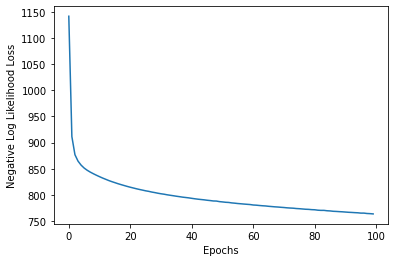

[1141.4564985148113, 911.5477136230469, 876.9121877034505, 864.6576655069987, 856.9885652669271, 851.3678340657552, 847.1161920166015, 843.594870300293, 840.5131461588542, 837.6178601074218, 834.9127162679036, 832.3102052815756, 829.931672261556, 827.5392698160807, 825.420815633138, 823.4861513264974, 821.5036345418295, 819.7331481933594, 818.0188065592448, 816.3232361857097, 814.7493493652344, 813.2831397501627, 811.8018049112956, 810.4687707519531, 809.1998732503255, 807.8942226155599, 806.863908996582, 805.529946492513, 804.479387105306, 803.2739594523111, 802.244026184082, 801.3954577636719, 800.2851153564453, 799.3668648274739, 798.4979143269857, 797.553823445638, 796.7220443725586, 795.8196554565429, 795.1395814005534, 794.4344638061524, 793.5175848388672, 792.6776666259766, 791.9133612060547, 791.2772331746419, 790.676665242513, 789.8753299967448, 789.2637438964844, 788.4974491373698, 788.3283682250976, 787.2684330240885, 786.6661595662434, 786.0087880452473, 785.671183573405, 7

In [29]:
# plt.ion()

fig = plt.figure()
plt.plot(train_loss_avgs)
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()

print(train_loss_avgs)